# План занятия:

Работа с видео в OpenCV
* Чтение видеофайла
* Запись видеофайла

Как раньше подходили к задаче детекции


OpenCV DNN 
* Классификация
* Детекция
* Открытие модели из pytorch




In [9]:
!pip3 install pafy youtube-dl
import os
from base64 import b64encode

import cv2
import pafy
import numpy as np

from IPython.display import HTML
from google.colab.patches import cv2_imshow

OpenCV позволяет нам работать с различными источниками видео: видео-файлами, вэб-камерой, последовательностью изображений и даже видео-стримами при помощи единого интерфейса. Для этого существует функция [cv2.VideoCapture()](https://docs.opencv.org/4.x/d8/dfe/classcv_1_1VideoCapture.html#ac4107fb146a762454a8a87715d9b7c96). 
Давайте загрузим видео с youtube. Далее будем работать с ним.
Для этого можем воспользоваться библиотекой [pafy](https://pypi.org/project/pafy/).

In [11]:
!mkdir -p input_files

url = 'https://youtu.be/Pd-KqIB3T4o'
video = pafy.new(url)
print(video)
best = video.getbest()
print(best.resolution, best.extension)

best.download(filepath=f'./input_files/video.{best.extension}')

Title: Мальчик сильно хотел шоколадку
Author: Валерий Шеронов
ID: Pd-KqIB3T4o
Duration: 00:00:21
Rating: 4.8893046
Views: 100648
Thumbnail: http://i.ytimg.com/vi/Pd-KqIB3T4o/default.jpg
640x360 mp4



Проверим, что видео скачалось и все ок.

In [12]:
video_path = './input_files/video.mp4'

# Show video
mp4 = open(video_path,'rb').read()

data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=640 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)


## Чтение видео

Давайте посмотрим, как работать с чтением видео при помощи OpenCV. 

Базовый алгоритм работы с классом VideoCapture выглядит следующим образом:
- создаем новый объект video capture
- читаем из него, пока это возможно или пока нам не надоест
- делаем какую-то обработку 
- сохраняем или выводим результаты
- освобождаем ресурсы, используемые video capture

Ниже приведен базовый скрипт, который мы сможем запустить из консоли и посмотреть на вывод результатов с камеры.


```python
import cv2

# создаем объект VideoCapture.
# Здесь 0 означает использование устройства /dev/video0. 
# мы бы могли написать cap = cv2.VideoCapture('/dev/video0')
cap = cv2.VideoCapture(0)

# цикл, пока видео открыто. Можем заменить просто бесконечным циклом.
while cap.isOpened():

    # Считываем новый кадр и success code.
    ret, frame = cap.read()

    # Здесь можно делать обработку изображений

    # отображаем изображение
    cv2.imshow('frame', frame)

    # Важный момент, waitKey позволяет взаимодействовать с клавиатурой.
    # данная строчка позволяет закрыть окно при нажатии клавиши q.
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# освобождаем ресурсы
cap.release()
cv2.destroyAllWindows()

```

Здесь может возникнуть вопрос насчет условия `if cv2.waitKey(1) & 0xFF == ord('q')`.

Если вкратце, то это нужно, чтобы независимо от платформы работало ри нажатии на клавишу q. 

Подробнее об этом рассказывают на [stackoverflow](https://stackoverflow.com/questions/35372700/whats-0xff-for-in-cv2-waitkey1).

Должно получиться примерно следующее окно.



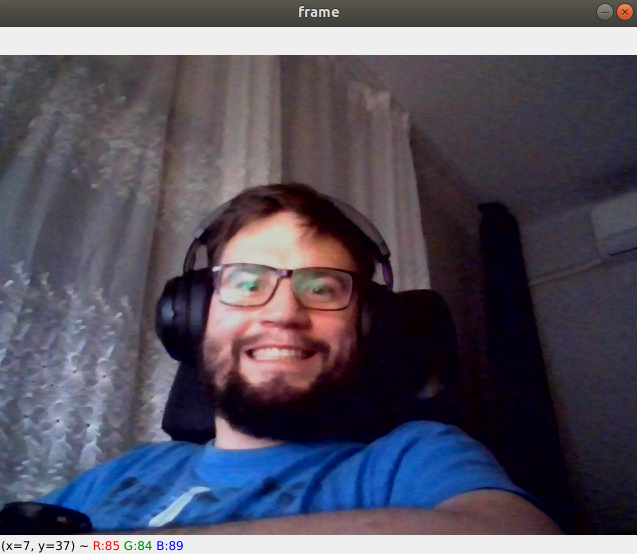

Заметим, что "под капотом" происходит много вещей. 




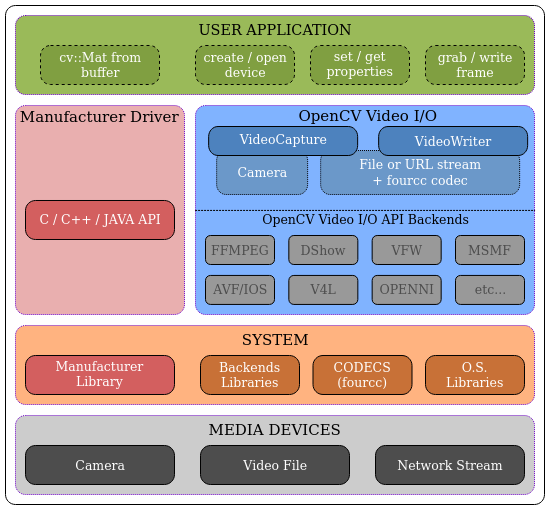

Стоит отметить, что из объекта VideoCapture можно не только вытягивать следующий фрейм. Мы также можем получить информацию о видео. Делается это при помощи метода [get()](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html#aa6480e6972ef4c00d74814ec841a2939). Список доступных опций смотрите [здесь](https://docs.opencv.org/3.4/d4/d15/group__videoio__flags__base.html#gaeb8dd9c89c10a5c63c139bf7c4f5704d).

Например, здесь, мы можем узнать разрешение видео и FPS.

In [17]:
cap = cv2.VideoCapture('./input_files/video.mp4')

print(f'width: {cap.get(cv2.CAP_PROP_FRAME_WIDTH)}')
print(f'height: {cap.get(cv2.CAP_PROP_FRAME_HEIGHT)}')
print(f'FPS: {cap.get(cv2.CAP_PROP_FPS)}')

cap.release()



width: 640.0
height: 360.0
FPS: 25.0


Мы также можем задавать некоторые опции при помощи метода [set()](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html#a8c6d8c2d37505b5ca61ffd4bb54e9a7c). Например, можем модифицировать предыдущий скрипт, чтобы изменять яркость в вэб камере:

```python
import cv2


cap = cv2.VideoCapture(0)
i = 0
while cap.isOpened():
    i += 1
    cap.set(cv2.CAP_PROP_BRIGHTNESS, i % 255)
    ret, frame = cap.read()
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

```

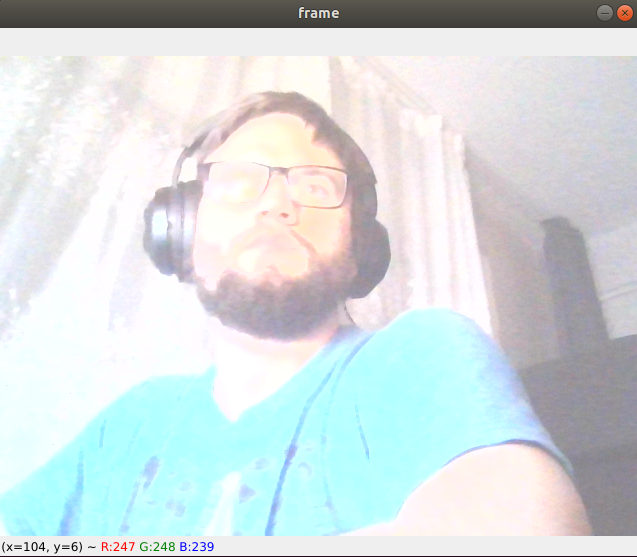

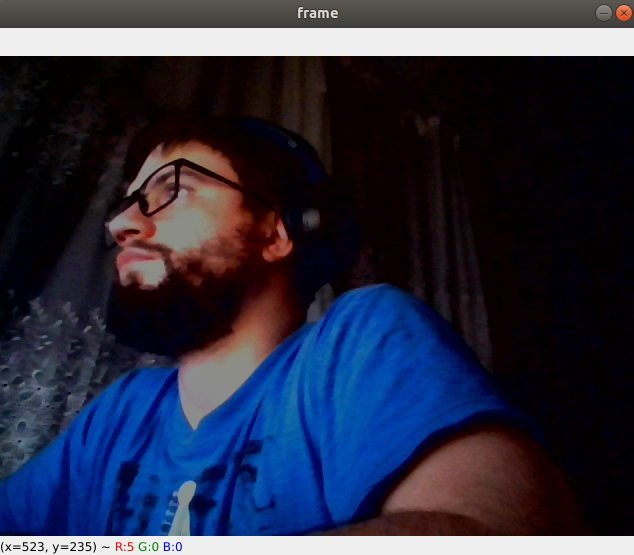

Стоит учесть, что не всякий раз, когда мы делаем get()/set() для какой-то опции мы получим/выставим то значение, которое мы хотели. Это все благодаря тому, что каждая такая операция вовлекает следующую цепочку взаимодействий:

```VideoCapture -> API Backend -> Operating System -> Device Driver -> Device Hardware```,

где на каждом шаге может пойти что-то не так.

Таким образом при разработке приложений необходимо учитывать и то, с какой аппаратурой мы будем взаимодействовать.


## Запись видео

Для записи видео используется класс [VideoWriter()](https://docs.opencv.org/4.5.4/dd/d9e/classcv_1_1VideoWriter.html#ac3478f6257454209fa99249cc03a5c59). "Под капотом" всю работу по кодированию видео исполняет библиотека FFMPEG.

Конструктор принимает следующие аргументы:

- **filename**	Имя выходного файла
- **fourcc**	4-х символьный код для кодека
- **fps**	Выходной фремрейт
- **frameSize**	Разрешение видео
- **isColor**	Записать ли видео цветным или конвертировать в черно-белое

Давайте прочитаем скачанное выше видео, переведем его в черно-белое и сохраним:

In [5]:
!mkdir -p output_files

In [6]:
cap = cv2.VideoCapture('./input_files/video.mp4')

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

output = cv2.VideoWriter(
    './output_files/video_gray.mp4', 
    cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
    fps,
    (width, height),
    0
)

while cap.isOpened():

    ret, frame = cap.read()
    if ret:
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        output.write(gray_frame)
    else:
        break


cap.release()
output.release()

In [7]:
video_path = './output_files/video_gray.mp4'
compressed_path = './output_files/video_gray_temp.mp4'
# compress video
os.system(f"ffmpeg -i {video_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=640 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)


# Решение задачи детекции без нейронных сетей

В 2001 году появился [алгоритм](https://www.face-rec.org/algorithms/boosting-ensemble/16981346.pdf) Виола-Джонса. Он основан на [признаках Хаара](https://en.wikipedia.org/wiki/Haar-like_feature). 
В OpenCV есть туториал с объяснением, как он [работает](https://docs.opencv.org/4.x/db/d28/tutorial_cascade_classifier.html) и как его можно [обучить](https://docs.opencv.org/4.x/dc/d88/tutorial_traincascade.html) на своих данных. 

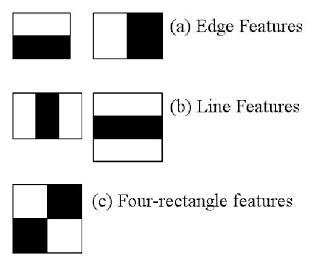

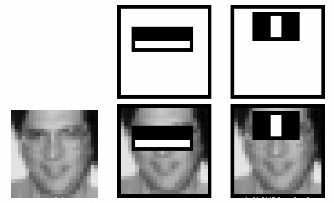

In [8]:
!mkdir -p haarcascades
!wget "https://raw.githubusercontent.com/opencv/opencv/4.x/data/haarcascades/haarcascade_frontalface_alt.xml" -q -O ./haarcascades/haarcascade_frontalface_alt.xml
!wget "https://raw.githubusercontent.com/opencv/opencv/4.x/data/haarcascades/haarcascade_eye_tree_eyeglasses.xml" -q -O ./haarcascades/haarcascade_eye_tree_eyeglasses.xml
!mkdir -p input_files & wget "https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png" -q -O ./input_files/lenna.png

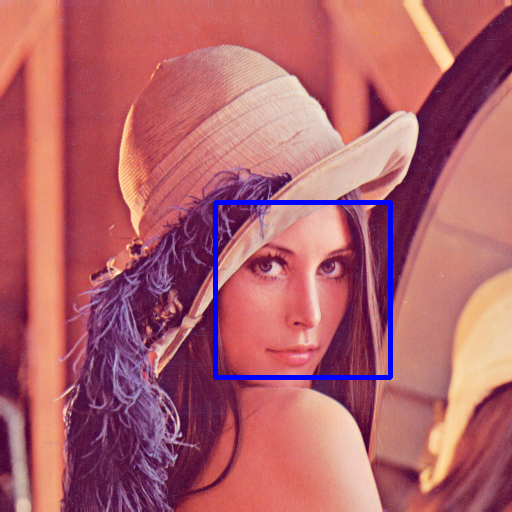

In [9]:
face_cascade = cv2.CascadeClassifier('./haarcascades/haarcascade_frontalface_alt.xml')
img = cv2.imread('./input_files/lenna.png')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(img_gray, 1.1, 5)

for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 3)


cv2_imshow(img)


In [14]:
def blur_image(image):
    resized = cv2.resize(image, (10, 10), interpolation=cv2.INTER_LINEAR)
    blurred = cv2.resize(resized, image.shape[:2], interpolation=cv2.INTER_NEAREST)
    return blurred

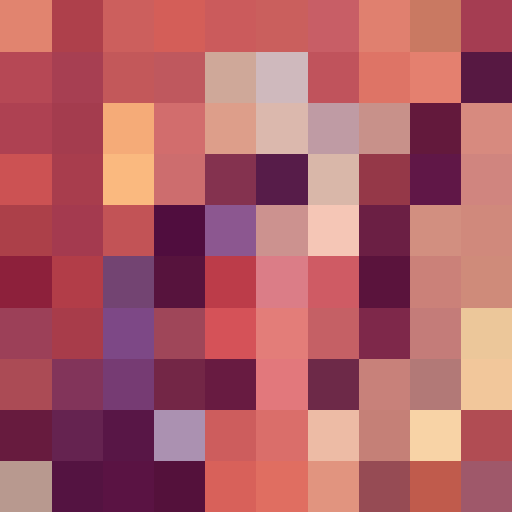

In [11]:
img = cv2.imread('./input_files/lenna.png')
img = blur_image(img)
cv2_imshow(img)

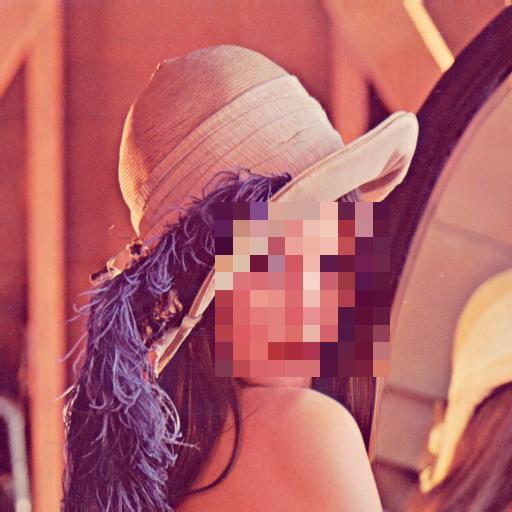

In [12]:
face_cascade = cv2.CascadeClassifier('./haarcascades/haarcascade_frontalface_alt.xml')
img = cv2.imread('./input_files/lenna.png')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(img_gray, 1.1, 5)

for (x, y, w, h) in faces:
    crop = img[y: y + w, x: x + h]
    blurred = blur_image(crop)
    img[y: y + w, x: x + h] = blurred


cv2_imshow(img)

## Задание

Мы выше познакомились с чтением и записью видео, классификатором на основе каскадов Хаара. Давайте теперь заблюрим все лица на скачанном в начале урока видео и сохраним результат.

In [19]:
OUTPUT_PATH = './output_files/video_blurred.mp4'

cap = cv2.VideoCapture('./input_files/video.mp4')
face_cascade = cv2.CascadeClassifier('./haarcascades/haarcascade_frontalface_alt.xml')


width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

output = cv2.VideoWriter(
    OUTPUT_PATH, 
    cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
    fps,
    (width, height),
    True
)

while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        faces = face_cascade.detectMultiScale(gray_frame, 1.1, 5)

        for (x, y, w, h) in faces:
            crop = frame[y: y + w, x: x + h]
            blurred = blur_image(crop)
            frame[y: y + w, x: x + h] = blurred
        output.write(frame)
    else:
        print('Something gone wrong')
        break

cap.release()
output.release()

Something gone wrong


In [20]:
compressed_path = './output_files/video_temp.mp4'
# compress video
os.system(f"ffmpeg -i {OUTPUT_PATH} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=640 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)


# OpenCV DNN модуль

DNN модуль позволяет загрузить и запустить модели, которые были обучены на других фреймворках.
Данный модуль не позволяет обучать модели. Мы можем только использовать уже обученные. 
В данный момент DNN модуль поддерживает следующие фреймворки:
- Caffe
- TensorFlow
- Torch
- Darknet
- Models in ONNX format 

Для многих операций реализовано использование ускорения при помощи инструкций SSE, AVX, AVX2 и NEON. Также возможно использование технологии CUDA для большинства слоев.

Подробное описание и туториалы можно найти [здесь](https://github.com/opencv/opencv/wiki/Deep-Learning-in-OpenCV).

Давайте рассмотрим как мы можем решить из коробки задачу классификации при помощи OpenCV DNN модуля.


## Задача классификации